In [ ]:
!nvidia-smi

Thu Sep 22 11:23:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download(r'https://www.kaggle.com/datasets/arunrk7/surface-crack-detection')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adarshshailendra
Your Kaggle Key: ··········


100%|██████████| 233M/233M [00:04<00:00, 59.2MB/s]


In [ ]:
from pathlib import Path as pt
negative_dir = pt(r'/content/surface-crack-detection/Negative')
positive_dir = pt(r'/content/surface-crack-detection/Positive')

In [ ]:
import pandas as pd
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [ ]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df.head()

,Filepath,Label
0,/content/surface-crack-detection/Positive/0696...,POSITIVE
1,/content/surface-crack-detection/Positive/0986...,POSITIVE
2,/content/surface-crack-detection/Positive/1428...,POSITIVE
3,/content/surface-crack-detection/Negative/0173...,NEGATIVE
4,/content/surface-crack-detection/Positive/0144...,POSITIVE


In [ ]:
df = all_df.sample(frac = 1).reset_index(drop = True)
df.head()

,Filepath,Label
0,/content/surface-crack-detection/Positive/0995...,POSITIVE
1,/content/surface-crack-detection/Negative/0029...,NEGATIVE
2,/content/surface-crack-detection/Negative/0969...,NEGATIVE
3,/content/surface-crack-detection/Negative/0537...,NEGATIVE
4,/content/surface-crack-detection/Negative/0469...,NEGATIVE


In [ ]:
df.shape

(40000, 2)

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [ ]:
train_data = image_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = image_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = image_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = [120,120,3]))
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
def train_gpu():
  with tf.device('/device:GPU:0'):
    history = model.fit(train_data,validation_data=val_data,epochs=50, callbacks = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience=5))
    return history

In [ ]:
history = train_gpu()

Epoch 1/50
105/105 [==============================] - 18s 58ms/step - loss: 0.5587 - accuracy: 0.7571 - val_loss: 0.4063 - val_accuracy: 0.9833
Epoch 2/50
105/105 [==============================] - 6s 55ms/step - loss: 0.3164 - accuracy: 0.9729 - val_loss: 0.2306 - val_accuracy: 0.9833
Epoch 3/50
105/105 [==============================] - 6s 54ms/step - loss: 0.1720 - accuracy: 0.9690 - val_loss: 0.1040 - val_accuracy: 0.9833
Epoch 4/50
105/105 [==============================] - 6s 54ms/step - loss: 0.1762 - accuracy: 0.9429 - val_loss: 0.1191 - val_accuracy: 0.9571
Epoch 5/50
105/105 [==============================] - 6s 59ms/step - loss: 0.0612 - accuracy: 0.9860 - val_loss: 0.0630 - val_accuracy: 0.9821
Epoch 6/50
105/105 [==============================] - 6s 59ms/step - loss: 0.0560 - accuracy: 0.9830 - val_loss: 0.0442 - val_accuracy: 0.9857
Epoch 7/50
105/105 [==============================] - 6s 55ms/step - loss: 0.0337 - accuracy: 0.9911 - val_loss: 0.0618 - val_accuracy: 0.978

In [ ]:
type(history)

keras.callbacks.History

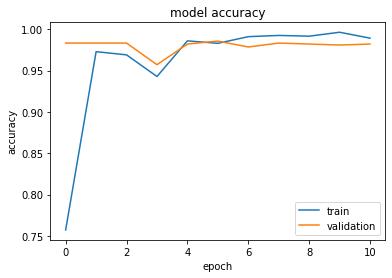

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

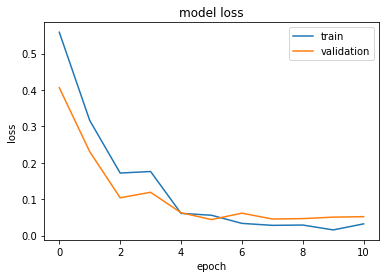

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
1model.evaluate(test_data)

57/57 [==============================] - 2s 42ms/step - loss: 0.0601 - accuracy: 0.9806


[0.06009606644511223, 0.980555534362793]

In [ ]:
test_data.class_indices

{'NEGATIVE': 0, 'POSITIVE': 1}

In [ ]:
import numpy as np
from keras.preprocessing import image
test_img = tf.keras.utils.load_img('/content/Test.jpg',
                         target_size = (120,120))
test_img = tf.keras.preprocessing.image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis = 0)
result = model.predict(test_img)
result

array([[0.99978787]], dtype=float32)

In [ ]:
test_img = tf.keras.utils.load_img('/content/Test0.jpg',
                         target_size = (120,120))
test_img = tf.keras.preprocessing.image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis = 0)
result = model.predict(test_img)
result

array([[0.00767531]], dtype=float32)

In [ ]:
# Shallow Neural network Approach
# Early-Stopping implemented to reduce Computational complexity and trainig time
# Early approach to a Custom Deep neural network